<a href="https://colab.research.google.com/github/danushaaditya/Food-Vision-101/blob/main/Food_Vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Big 101 🍔

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
- Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

## Importing the required Libraries

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a9c867c3-d1ac-567d-ccd5-704626d03236)


In [ ]:
!nvidia-smi #Teslas T4 is a 15GB GPU offered by Colab for free.

Sun May 21 04:56:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import tensorflow as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime
import zipfile
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
print(tf.__version__)
print(datetime.datetime.now())

2.12.0
2023-05-21 06:37:41.563723


## Downloading the Dataset

In [ ]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-05-21 05:12:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   226MB/s    in 6.6s    

2023-05-21 05:12:40 (236 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
print(f"Total number of classes: {len(os.listdir(train_dir))}")
print(f"Total number of training images per class: {len(os.listdir(train_dir+'apple_pie/'))}")
print(f"Total number of testing images per class: {len(os.listdir(test_dir+'apple_pie/'))}")

Total number of classes: 101
Total number of training images per class: 75
Total number of testing images per class: 250


In [ ]:
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                shuffle=False,
                                                                image_size=IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Feature Extraction

In [ ]:
#ModelCheckpoint Callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
#Data Augemntation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    #Rescaling is not required for EfficientNetB0
], name="data_augmentation")

In [ ]:
#Downloading the transfer learned model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architectire with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_later")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_later (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
#Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 127s 463ms/step - loss: 3.3717 - accuracy: 0.2725 - val_loss: 2.5185 - val_accuracy: 0.4338
Epoch 2/5
237/237 [==============================] - 73s 305ms/step - loss: 2.1883 - accuracy: 0.5002 - val_loss: 2.0913 - val_accuracy: 0.4897
Epoch 3/5
237/237 [==============================] - 62s 260ms/step - loss: 1.8171 - accuracy: 0.5650 - val_loss: 1.8994 - val_accuracy: 0.5188
Epoch 4/5
237/237 [==============================] - 59s 247ms/step - loss: 1.6038 - accuracy: 0.6117 - val_loss: 1.8345 - val_accuracy: 0.5291
Epoch 5/5
237/237 [==============================] - 54s 225ms/step - loss: 1.4475 - accuracy: 0.6457 - val_loss: 1.7707 - val_accuracy: 0.5331


In [ ]:
#Evaluate the model on full test data
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 57s 73ms/step - loss: 1.5977 - accuracy: 0.5780


[1.597726583480835, 0.5780197978019714]

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

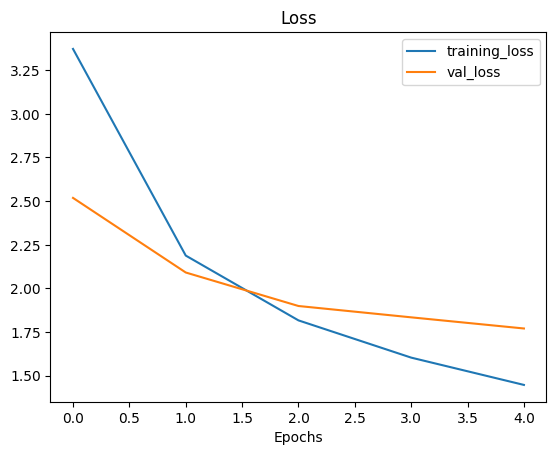

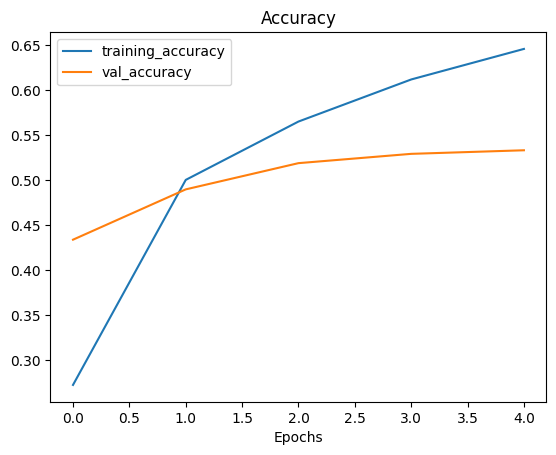

In [ ]:
#Plotting the loss curves
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

To fine tune the existing model, we follow the following steps:
- It is advised in general to first train the base model using feature extraction.
- Load the feature-extracted model using checkpoints.
- Unfreeze the last few layers.
- Compile the entire model again because we made changes.
- Train the model now with unfrozen layers.
- Compare with the feature extracted model for inference.

In [ ]:
#Freeze all the layers in the base model
base_model.trainable = False

#Freeze all the layers except the last 5 layers
for layer in base_model.layers[-5:]:
  layer.trainable = True

#Verify
for layer in base_model.layers:
  print(layer.name, layer.trainable) #VERIFIED

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
#Recompiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
#Fine-tune the model for 5 more epochs
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch=len(train_data_all_10_percent),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 74s 278ms/step - loss: 1.3011 - accuracy: 0.6842 - val_loss: 1.7278 - val_accuracy: 0.5519
Epoch 6/10
237/237 [==============================] - 52s 217ms/step - loss: 1.2773 - accuracy: 0.6950 - val_loss: 1.7228 - val_accuracy: 0.5519
Epoch 7/10
237/237 [==============================] - 50s 205ms/step - loss: 1.2589 - accuracy: 0.7010 - val_loss: 1.7154 - val_accuracy: 0.5530
Epoch 8/10
237/237 [==============================] - 48s 202ms/step - loss: 1.2335 - accuracy: 0.7077 - val_loss: 1.7184 - val_accuracy: 0.5493
Epoch 9/10
237/237 [==============================] - 47s 196ms/step - loss: 1.2248 - accuracy: 0.7114 - val_loss: 1.7112 - val_accuracy: 0.5530
Epoch 10/10
237/237 [==============================] - 42s 177ms/step - loss: 1.2079 - accuracy: 0.7208 - val_loss: 1.7056 - val_accuracy: 0.5532


In [ ]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 56s 71ms/step - loss: 1.5376 - accuracy: 0.5968


[1.5375667810440063, 0.5968316793441772]

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

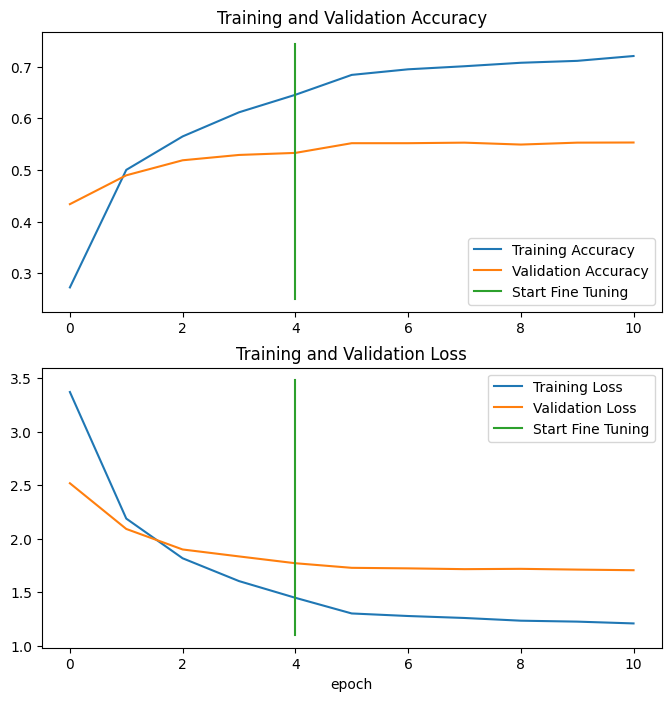

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Evaluating the performance

In [ ]:
#Get the prediction labels
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 67s 81ms/step


In [ ]:
#Getting the location of all the classes with respect to softmax
pred_classes = pred_probs.argmax(axis=1)
pred_classes.shape

(25250,)

In [ ]:
#Getting the actual labels
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

In [ ]:
#Get accuracy score by comparing predicted classes to ground truth labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5968316831683168

## Visualizing predictions on test images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 52ms/step


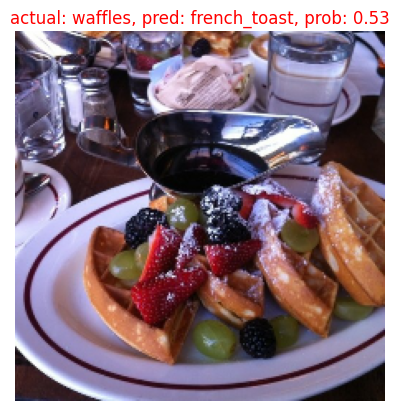

In [ ]:
class_names = test_data.class_names
class_name = random.choice(class_names)
filename = random.choice(os.listdir(test_dir + "/" + class_name))
filepath = test_dir + class_name + "/" + filename

# Load the image and make predictions
img = load_and_prep_image(filepath, scale=False)
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()]
plt.imshow(img/255.)
if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
  title_color = "g"
else:
  title_color = "r"
plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);